### Libraries & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn  import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, SVMSMOTE  
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

random_state=42

##  Dataset

In [2]:
df = pd.read_csv('bank-full.csv', sep = ';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [3]:
# dataset with social economic features
df_new = pd.read_csv('bank-additional-full.csv', sep = ';')
df_new.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# get categorical data
categorical_features = df.select_dtypes(include=['object'])
#categorical_features

In [5]:
# get numerical data
Numeric_data = df.select_dtypes(include='number')
#Numeric_data

- Isolate the features and the target values.

- The target variable(y) is the last column in the Data Frame and hence using slicing, can separate them into feature and label.

In [6]:
# get all categorical feature except target vale y(deposit)
feature = categorical_features.iloc[:,:-1].values

In [7]:
label = categorical_features.iloc[:,-1].values
#label

### Correlation Matrix of the Numerical Features:

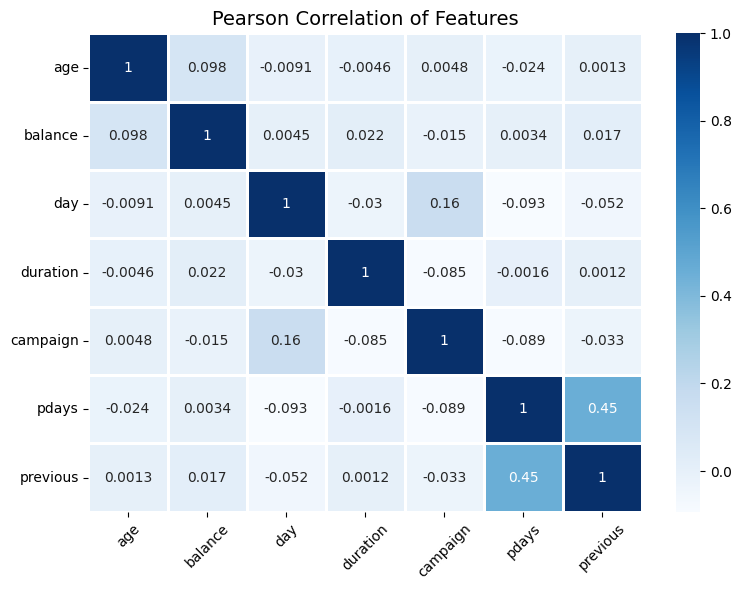

In [8]:
corr = df.corr()

# plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df.corr(), cmap='Blues', annot=True, square=False, linewidth=1, xticklabels=corr.columns, yticklabels=corr.columns, annot_kws={"size": 10}, ax=ax)
ax.set_title('Pearson Correlation of Features', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
fig.tight_layout()

**Observation**

- it seems **no** feature is heavily correlated with other features

### Imbalanced target value

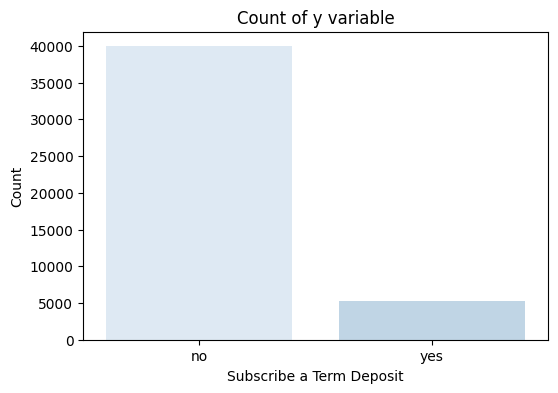

In [9]:
# set the color palette
sns.set_palette("Blues")

# plot the countplot
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df)
plt.title("Count of y variable")
plt.xlabel("Subscribe a Term Deposit")
plt.ylabel("Count")
plt.show()

#  Pre_processing

### Drop Unnecessary Columns 

In [10]:
# According to EDA, some features like day,month have no affect on subscribition

df.drop(['day', 'month'], axis=1, inplace=True)

- There are no missing values in this dataset. However, there are values labeled as unknown, which can be considered similar to missing values.



- The unknown values for the job and education columns are randomly distributed throughout those columns, indicating that they were not recorded or were otherwise unavailable. In this case, we may want to consider treating these unknown values as missing and imputing them using a suitable imputation method.



- The unknown values for the poutcome column represent the outcome of the previous marketing campaign for customers who were not previously contacted. To handle these values, we could segment the entire column into two categories: success and not success, based on whether the previous marketing campaign was successful or not. This would allow us to retain the information in the poutcome column without introducing missing values into the dataset.

    
- Overall, it is important to carefully consider the treatment of unknown values and missing values in the dataset to ensure that they do not bias the analysis or lead to inaccurate conclusions.

### Impute the Unknown Values

In [11]:
# Define the list of columns to impute
columns_to_impute = ['job', 'education']


# Loop over each column and impute unknown value
for i in columns_to_impute:
    # Compute the normalized value counts for non-unknown values
    value_counts = df.loc[df[i] != 'unknown', i].value_counts(normalize=True)
    df.loc[df[i] == 'unknown', i] = np.random.choice(value_counts.index, 
                                                       p = value_counts.values, size = df.loc[df[i]  == 'unknown'].shape[0] )

In [12]:
# 'unknown', 'failure', and 'other' indicate a lack of success in the previous marketing campaign
# We are replacing these values with 'not success' to simplify the analysis
# Note that the 'success' values are retained as-is
df['poutcome'] = df['poutcome'].replace({'unknown':'not success', 'failure':'not success', 'other':'not success'})

# Check the unique values in the original column
print(df['poutcome'].unique())

['not success' 'success']


### Transforem some Columns

In [13]:
df = df.rename(columns={'y': 'deposit'}) # Rename the target value
df['deposit'] = df['deposit'].map({'yes': 1, 'no': 0}) # Define new columns for deposit yes and no

df['duration'] = df['duration'].apply(lambda n: n / 60).round(2) #Change the unit of 'duration' from sec to min

# Encoding

-  According to litreature in the case of imbalanced data, using label encoding could result in an unintended bias towards the majority class. 


- This is because the numerical values assigned to each category may cause the model to treat the majority class as more important than the minority class. On the other hand, using dummy encoding could result in a more balanced representation of the categories, but it may also increase the risk of overfitting to the minority class.


-  However, I try both methods and  got slightly better results on dummy than label encoding.

### Dummy Encoding the Categorical Feature

In [14]:
#Convert categorical variables to dummy variables
df_dummy = pd.get_dummies(df[['job', 'marital', 'education', 'poutcome', 'contact']])

# Drop original categorical columns
df = df.drop(['job', 'marital', 'education', 'poutcome', 'contact'], axis=1)

#First Convert the object to Boolean
df['housing'] = df['housing'].astype(bool)
df['loan'] = df['loan'].astype(bool)
df['default'] = df['default'].astype(bool)

#Convert Boolean variables to integers
df['housing'] = df['housing'].astype('int')
df['loan'] = df['loan'].astype('int')
df['default'] = df['default'].astype('int')

# Concatenate encoded categorical variables with numerical variables
df = pd.concat([df_dummy, df], axis=1)

#Check the first few rows of the new DataFrame
df.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,poutcome_not success,poutcome_success,contact_cellular,contact_telephone,contact_unknown,age,default,balance,housing,loan,duration,campaign,pdays,previous,deposit
0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,58,1,2143,1,1,4.35,1,-1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,44,1,29,1,1,2.52,1,-1,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,33,1,2,1,1,1.27,1,-1,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,47,1,1506,1,1,1.53,1,-1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1,33,1,1,1,1,3.30,1,-1,0,0


#  Prepare the features and target variable

In [15]:
X = df.drop('deposit',axis=1)
y = df['deposit']

In [16]:
X.shape, y.shape

((45211, 31), (45211,))

# Feature Scaling

In [17]:
#Normalize the features
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
x_scaled = scaler.fit_transform(X)
columns = X.columns
X = pd.DataFrame(x_scaled, columns=columns)
#x_scaled contains the normalized features

# Train-Test Split¶

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 
X_train.shape, y_train.shape, X_test.shape, y_test.shape
#stratify-> target value distribution unchanged

((36168, 31), (36168,), (9043, 31), (9043,))

## Cross validate to check which model performs better 

- Stratified sampling: Using **stratified** to keeping the target values distibution unchanged

In [19]:
# create a splitter object
stratified = StratifiedShuffleSplit(n_splits=5,test_size=0.2, random_state=42) 

In [20]:
# Define the models to compare
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('Random Forest', RandomForestClassifier(random_state=42))
]

# Calculate cross-validation scores for each model
for name, model in models:
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, scoring='accuracy', cv=stratified)
    print(f'{name} CV Score:', cv_score.mean())


Logistic Regression CV Score: 0.9012994194083493
KNN CV Score: 0.8907105335913741
Random Forest CV Score: 0.8991982305778269


**Insight**

- We can not make a decision based on cross validation since all the theree models perform quite similar



- Hence based on cross validation on the train set,  all of the models are quite good, and does not give significant difference


# Create List for Collecting the Results

In [21]:
# two empthy list to append all the results
accu = []
methods = []

# This function is to plot the confusion matrix

In [22]:
def plot_confusion_matrix(y_test, y_pred, labels=None):
    """
    Plot a confusion matrix for the given true and predicted labels.
    Optionally, provide a list of label names to use for the plot.
    """
    if labels is None:
        labels = np.unique(y_pred)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title('Confusion Matrix')
    plt.show()

# Model Building

Use **binary classification** algorithms for predicting the "deposit" variable, which has a "Yes/No" value.
In this project, we will be using three supervised models:

- Logistic Regression

- K-Nearest Neighbors

- Random Forest

## Logistic Regression

In [23]:
# Fit Logistic Regression model on the training data
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = lr.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = lr.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

# evaluate
confusion_matrix(y_test,test_prediction)

Training accuracy: 0.9000221190002212
Test accuracy: 0.8989273471193188


array([[7808,  177],
       [ 737,  321]], dtype=int64)

In [24]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.64      0.30      0.41      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043



# Hyperparameters Tuning (Logistic Regression)

In [25]:
%%time

# Define logistic regression model
lr_cv = LogisticRegression(random_state=42)


# The highest class weight in this list assigns 50 times more weight to the(class 1) than to(class 0).
# Define the range of class_weight
#'class_weight': [{0: 1, 1: w} for w in np.linspace(1, 50, 50)] -> better but takes too much time 

#class_freq = dict(df['deposit'].value_counts(normalize=True))
#class_weights = []
#for cls, freq in class_freq.items():
    #weight = len(df) / (len(class_freq) * freq)
    #class_weights.append({cls: weight})

class_weights = [{0: 1, 1: w} for w in [3, 5, 7, 10,12]] 

# Define hyperparameters to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': np.logspace(-3, 3, 7),
    'class_weight': class_weights,
    'solver': ['liblinear']}

# Create GridSearchCV object
grid_search = GridSearchCV(lr_cv, param_grid, cv=stratified, scoring='f1_macro')

# Fit grid search to training data
grid_search.fit(X_train, y_train)

# Get the best estimator and score
best_lr = grid_search.best_estimator_  # best combination of hyperparameters 
best_score = grid_search.best_score_    # refers to the value of the scoring metric achieved by the best estimator.

# Evaluate the best estimator on the test data
y_pred = best_lr.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

print('tuned hyperparameters: (best parameters)', grid_search.best_params_)

# appeand the test results
# Evaluate the best estimator on the test data

accu.append(best_lr.score(X_test,y_test))
methods.append('Logistic Regression')
print('X_test Accuracy:', best_lr.score(X_test,y_test))

Best F1 score: 0.7404229510843046
Test F1 score: 0.538532110091743
tuned hyperparameters: (best parameters) {'C': 1.0, 'class_weight': {0: 1, 1: 3}, 'penalty': 'l2', 'solver': 'liblinear'}
X_test Accuracy: 0.8887537321685282
CPU times: total: 1min 43s
Wall time: 2min 9s


## Confusion Matrix for logistic Regression

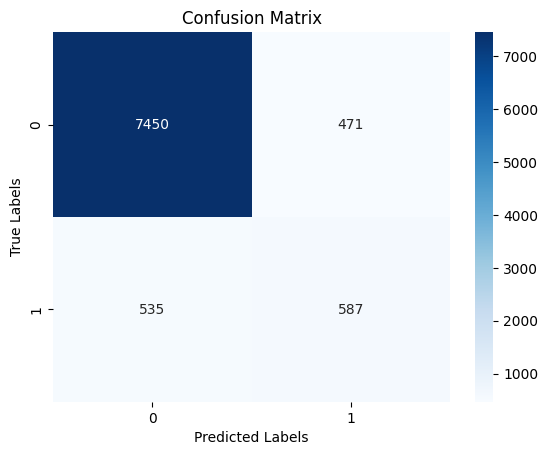

In [26]:
predictions= best_lr.predict(X_test)

plot_confusion_matrix(y_pred, y_test, labels=[0, 1])

In [27]:
print(classification_report(y_test,y_pred,target_names=['not deposit', 'deposit']))

              precision    recall  f1-score   support

 not deposit       0.94      0.93      0.94      7985
     deposit       0.52      0.55      0.54      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.74      0.74      9043
weighted avg       0.89      0.89      0.89      9043



- Low recall means that model is struggling with classifying deposit cases

- As we try to decrease both false positive and false negative, the f1 score can be excellent metric.


- The ROC and AUC is also an intrsting metric that can show the model's effectiveness. we do it after this section.


- AUC closer to 1 means the model is highly effective

# K Nearest Neighbors

In [28]:
# Fit model on the training data
np.random.seed(42)

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = knn.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

# evaluate
confusion_matrix(y_test,test_prediction)

Training accuracy: 0.9060495465604954
Test accuracy: 0.8920712153046555


array([[7840,  145],
       [ 831,  227]], dtype=int64)

In [29]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7985
           1       0.61      0.21      0.32      1058

    accuracy                           0.89      9043
   macro avg       0.76      0.60      0.63      9043
weighted avg       0.87      0.89      0.87      9043



## Hyperparameters Tuning (KNN)

In [30]:
%%time


# Create a k-NN classifier with class weights
knn_cv = KNeighborsClassifier(n_neighbors=10, weights='distance') # How to weight each neigbour 
                                                                  #gives more weight to close neighbour

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

# classes are the unique class labels in y_train
#classes = np.unique(y_train)

# compute the class weights based on inverse of class frequency
#class_weights = compute_class_weight('balanced', classes, y_train)


# Compute class weights
#class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)


## Define hyperparameters to search over
param_grid = {'n_neighbors': [3, 5, 7, 9],
              'algorithm': ['auto'],
              'weights': ['distance', 'uniform']}

# Create GridSearchCV object
grid_search = GridSearchCV(knn_cv, param_grid, cv=stratified, scoring='f1_macro',n_jobs=-1)# f1_macro-> imbalanced data


# Fit grid search to training data
grid_search.fit(X_train, y_train)


# Get the best estimator and score
best_knn = grid_search.best_estimator_  #obtain the best estimator from the grid search 
best_score = grid_search.best_score_


# Evaluate the best estimator on the test data
y_pred = best_knn.predict(X_test)
test_score = f1_score(y_test, y_pred)


print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

print('tuned hyperparameters: (best parameters)', grid_search.best_params_)

# append the Knn test Results
accu.append(best_knn.score(X_test,y_test))
methods.append('KNN')
print('X_test Acuracy:',best_knn.score(X_test,y_test))

Best F1 score: 0.6721692355428285
Test F1 score: 0.37911746426351767
tuned hyperparameters: (best parameters) {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
X_test Acuracy: 0.8895278115669578
CPU times: total: 18 s
Wall time: 1min 10s


## Confusion matrix for KNN

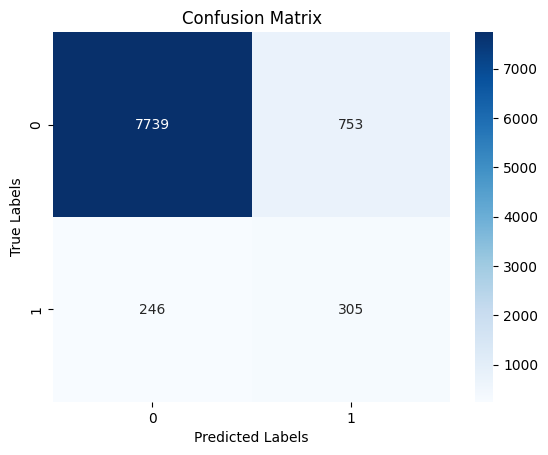

In [31]:
y_pred= best_knn.predict(X_test)

plot_confusion_matrix(y_pred, y_test, labels=[0, 1])

In [32]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7985
           1       0.55      0.29      0.38      1058

    accuracy                           0.89      9043
   macro avg       0.73      0.63      0.66      9043
weighted avg       0.87      0.89      0.87      9043



# Random Forest

In [33]:
# Fit Random Forest model on the training data
# Model was overfitted:I reduced the n_estimator to 50 and increased the min_samples_split to 10 to add regularization to model 
rf = RandomForestClassifier(random_state=42, n_estimators=50, min_samples_split=10)
rf.fit(X_train, y_train)

# Evaluate the performance on the training data
train_accuracy = rf.score(X_train, y_train)
print("Training accuracy:", train_accuracy)

# Evaluate the performance on the test data
test_prediction = rf.predict(X_test)
test_accuracy = accuracy_score(y_test, test_prediction)
print("Test accuracy:", test_accuracy)

# Check for overfitting by comparing train and test accuracy
if abs(train_accuracy - test_accuracy) > 0.1:
    print("Warning: Overfitting detected")

# Train and test accuracy are quite close so we don't seem to have too much overfitting

# evaluate
confusion_matrix(y_test,test_prediction)

Training accuracy: 0.9499834107498341
Test accuracy: 0.9006966714585868


array([[7782,  203],
       [ 695,  363]], dtype=int64)

In [34]:
print(classification_report(y_test,test_prediction))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.34      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043



## Hyperparameters  Tuning (Random Forest)

In [35]:
%%time
# Define the random forest classifier 
rf_1 = RandomForestClassifier(random_state=42)


# Define the class_weight (gives equall importance to the classes)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_rf = [{0:class_weights[0],1:class_weights[1]}]

# Number of trees in random forest
n_estimators = [10, 30, 50, 70, 90]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [3, 5, 7, 9]

# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]


parameters = {'n_estimators': n_estimators , 
                  'criterion' : [ 'entropy'], 
                  'max_depth': max_depth, 
                  'max_features': ['auto','sqrt'],
            'class_weight':class_weights_rf}


# Define the resampling technique (ensure the model have enough samples from the minority)
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)


# Define the GridSearch Object
grid_search = GridSearchCV(rf_1,parameters, cv=stratified, scoring='f1_macro', n_jobs=-1)



# Fit grid search to training data
grid_search.fit(X_train, y_train)
#grid_search.fit(X_train, y_train.ravel())


# Get the best estimator and score
best_rf = grid_search.best_estimator_  #obtain the best estimator from the grid search 
best_score = grid_search.best_score_


# Evaluate the best estimator on the test data
y_pred = best_rf.predict(X_test)
test_score = f1_score(y_test, y_pred)

print(f"Best F1 score: {best_score}")
print(f"Test F1 score: {test_score}")

accu.append(best_rf.score(X_test,y_test))
methods.append('Random Forest')
print('X_test Acuracy:',best_rf.score(X_test,y_test))


Best F1 score: 0.7007180327594398
Test F1 score: 0.5022475277195086
X_test Acuracy: 0.8163220170297467
CPU times: total: 4.25 s
Wall time: 1min 41s


In [36]:
class_weights

array([0.56623978, 4.27416686])

In [37]:
class_weights_rf

[{0: 0.5662397845758838, 1: 4.27416686362562}]

# Confusion matrix for Random Forest

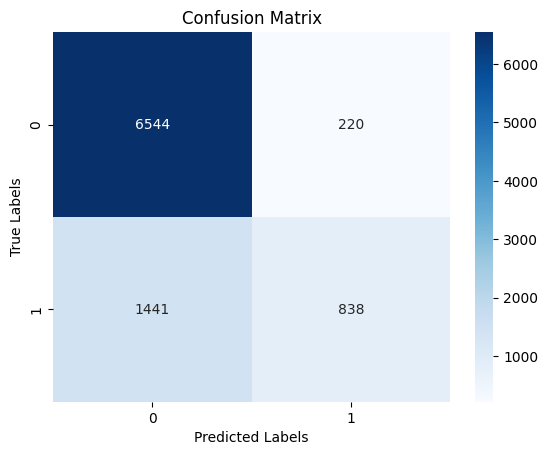

In [38]:
y_pred= best_rf.predict(X_test)

plot_confusion_matrix(y_pred, y_test, labels=[0, 1])

In [39]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      7985
           1       0.37      0.79      0.50      1058

    accuracy                           0.82      9043
   macro avg       0.67      0.81      0.69      9043
weighted avg       0.90      0.82      0.84      9043



# The Best Performed Model

In [40]:
print(methods)
print(accu)

['Logistic Regression', 'KNN', 'Random Forest']
[0.8887537321685282, 0.8895278115669578, 0.8163220170297467]


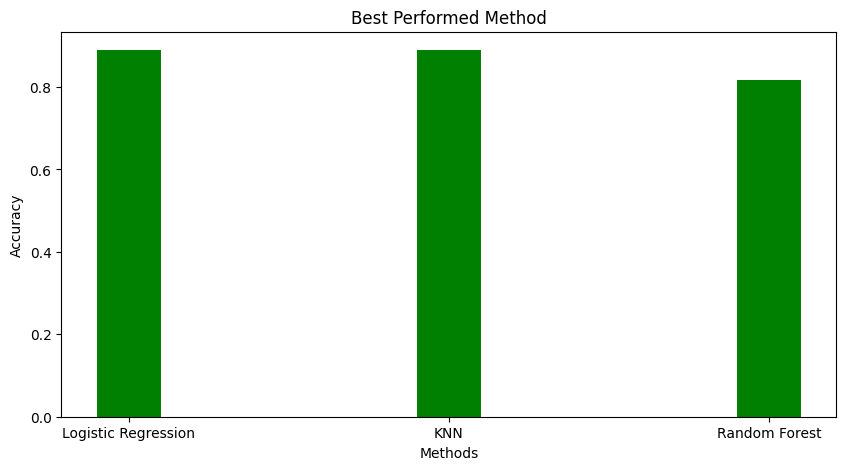

In [41]:
fig=plt.figure(figsize=(10,5))

#creating the bar plot
plt.bar(methods,accu,color='g',width=0.2)

plt.xlabel('Methods')
plt.ylabel('Accuracy')
plt.title('Best Performed Method')
plt.show()

# Model Effectivness


### see ROC Curve (Receiver Operating Curve) & AUC

- The ROC curve tells us how well our classifier is classifying between term deposit suscriptions (True Positives) and non-term deposit suscriptions. 


- The X-axis is represented by False positive rates (Specificity) and the Y-axis is represented by the True Positive Rate (Sensitivity.) 


- As the line moves the threshold of the classification changes giving us different values. The closer is the line to our top left corner the better is our model separating both classes.

Text(0.5, 1.0, 'Area under ROC')

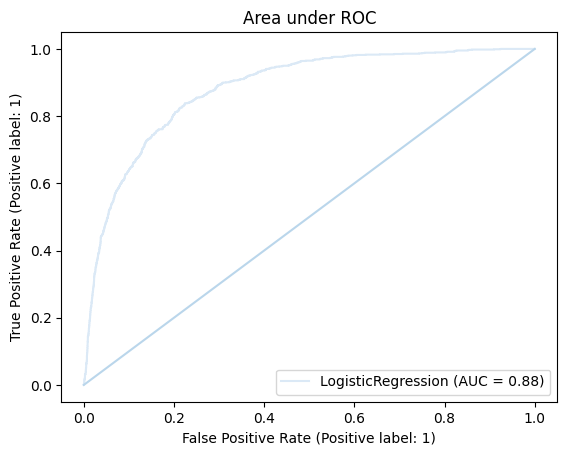

In [42]:
RocCurveDisplay.from_estimator(best_lr,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

Text(0.5, 1.0, 'Area under ROC')

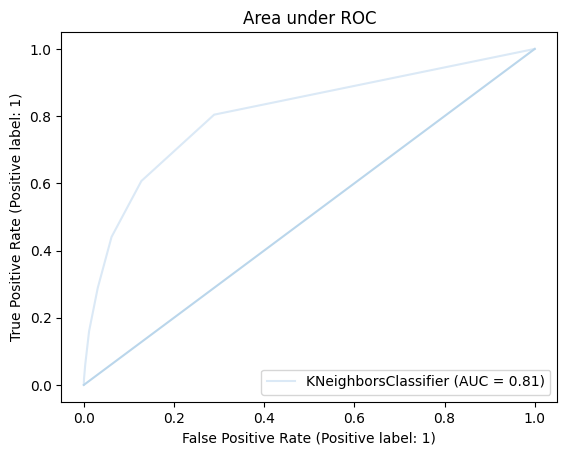

In [43]:
RocCurveDisplay.from_estimator(best_knn,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

Text(0.5, 1.0, 'Area under ROC')

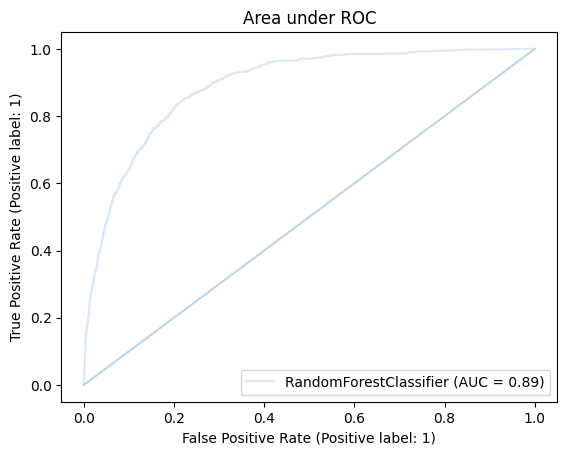

In [44]:
RocCurveDisplay.from_estimator(best_rf,X_test,y_test)
plt.plot([0,1],[0,1])
plt.title('Area under ROC')

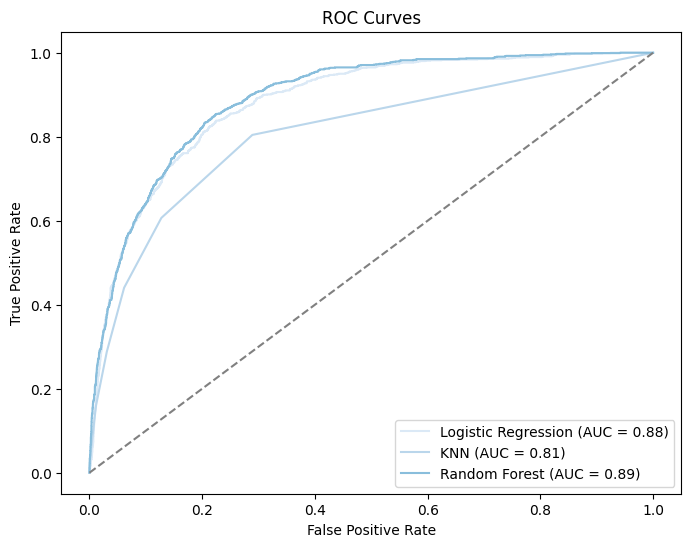

In [45]:
from sklearn.metrics import RocCurveDisplay

# Create a figure and axes object
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the ROC curve for each model
RocCurveDisplay.from_estimator(best_lr, X_test, y_test, ax=ax, name='Logistic Regression')
RocCurveDisplay.from_estimator(best_knn, X_test, y_test, ax=ax, name='KNN')
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, ax=ax, name='Random Forest')

# Plot the diagonal line
ax.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add axis labels and a title
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves')

# Add a legend
ax.legend()


**Results and Conclusion**

- In all the models selected with hyperparameter tuning, there was a slightly significant difference in terms of accuracy and AUC evaluation metrics, Neverthless the Random Forest Classifier had higher AUC scores of 0.89. 

- The figure Above shows the different metric scores of the Random Forest model used. There was a slightly significant difference in the scores while using Stratified k-fold cross-validation. 

**Discussion on Evaluation** 

- Given that the **Random Forest model** demonstrated better **recall and f1-score** for the **minority** class, which is crucial for determining whether a potential client would subscribe to the term deposit, it would be advisable for the bank to utilize this model.




- Moreover, by employing various hyperparameter tuning techniques, it is possible to further enhance the model's performance and achieve even better scores.